# Image analysis of colony growth 

© 2021 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

***

In this notebook we are going to use microscopy data of bacteria to determine their growth rate. In order to do that, we took images of the same colony over a period of about 1-2 hours.

In [79]:
import os

# For numerical computation
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For cool interactive stuff
import panel as pn

# For image analysis
import skimage.io

# To find files
import glob

# This enables high resolution graphics inline
%config InlineBackend.figure_format = 'retina'
pn.extension()
sns.set()

The first step is to set the path to the data set.

In [3]:
# Define directory where images exist
datadir = '../../data/ecoli_growth/'

# List TRITC images
files = glob.glob(datadir + '*TRITC*.tif')
files[0:5]

['../../data/ecoli_growth/ecoli_TRITC_18.tif',
 '../../data/ecoli_growth/ecoli_TRITC_19.tif',
 '../../data/ecoli_growth/ecoli_TRITC_09.tif',
 '../../data/ecoli_growth/ecoli_TRITC_20.tif',
 '../../data/ecoli_growth/ecoli_TRITC_08.tif']

Let's load an image into memory.

In [5]:
# Read example image into memory
im = skimage.io.imread(files[0])

# Let's show an image
im

array([[206, 205, 206, ..., 203, 203, 205],
       [206, 204, 204, ..., 203, 203, 205],
       [205, 205, 205, ..., 203, 203, 204],
       ...,
       [205, 203, 204, ..., 205, 205, 205],
       [205, 205, 205, ..., 203, 204, 205],
       [205, 205, 205, ..., 204, 205, 206]], dtype=uint16)

As we can see, an image is just a two dimensional array of intensities. We can look at an image by using the `imshow` function of pyplot. Since we only have one channel, we will simply use a grey scale to show the image. Some images can have multiple channels in order to image different things at the same time (such as fluorescent proteins with varying emission wavelengths).

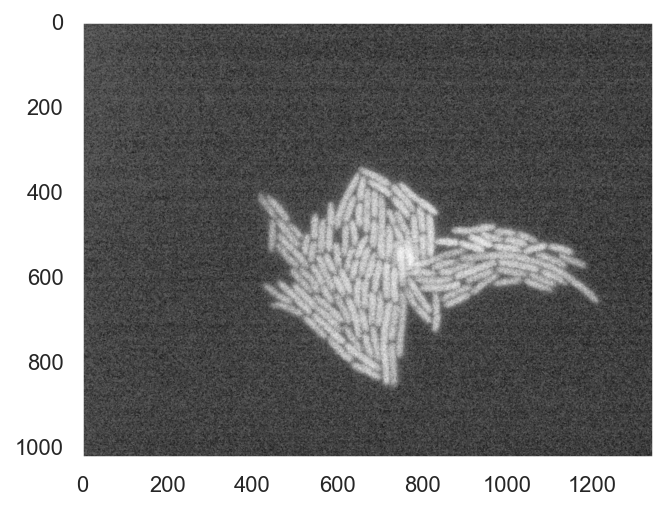

In [17]:
plt.imshow(im, cmap=plt.cm.Greys_r)
plt.grid(False)

A good step is to normalize the intensity values, such that they range from 0 to 1. This allows us to compare different images to each other.

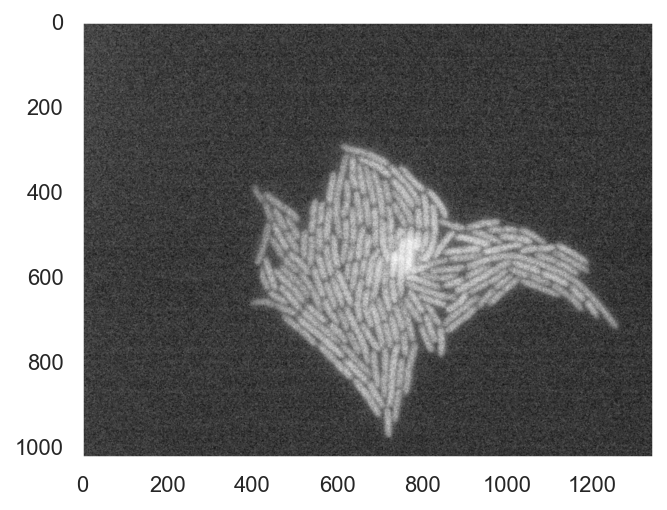

In [57]:
# Normalize image
im_float = (im - im.min()) / (im.max() - im.min())

# Display normalized image
plt.imshow(im_float, cmap=plt.cm.Greys_r)
plt.grid(False)

The image looks the same to us, but that is only due to the automatic scaling of the colormap that pyplot does in the background. To be sure that we successfully transformed the image, let's take a look at the actual values of the array.

In [58]:
im_float

array([[0.27272727, 0.27272727, 0.22727273, ..., 0.18181818, 0.18181818,
        0.18181818],
       [0.18181818, 0.18181818, 0.18181818, ..., 0.18181818, 0.18181818,
        0.18181818],
       [0.18181818, 0.18181818, 0.18181818, ..., 0.18181818, 0.18181818,
        0.22727273],
       ...,
       [0.27272727, 0.27272727, 0.27272727, ..., 0.13636364, 0.18181818,
        0.18181818],
       [0.22727273, 0.22727273, 0.22727273, ..., 0.13636364, 0.18181818,
        0.18181818],
       [0.22727273, 0.22727273, 0.22727273, ..., 0.13636364, 0.22727273,
        0.22727273]])

Let's look at a histogram of intensity values. 

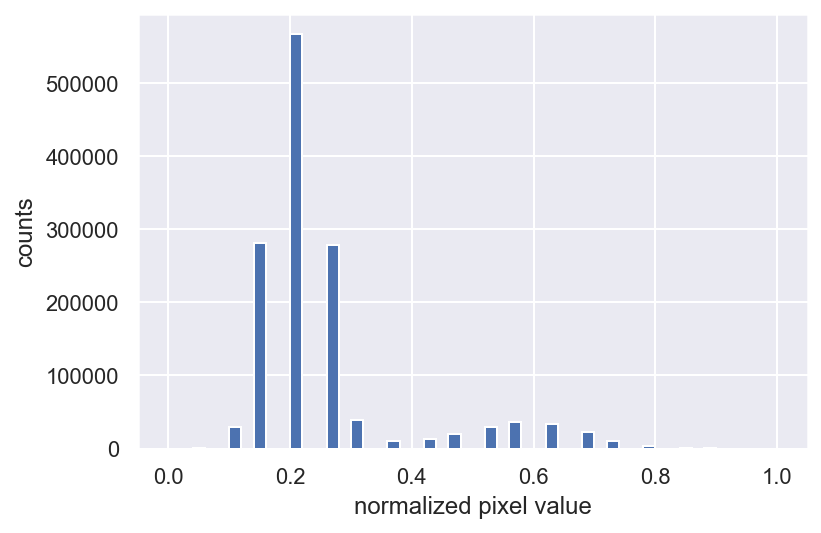

In [38]:
plt.hist(im_float.flatten(), bins=50, range=(0,1))
plt.xlabel('normalized pixel value')
_ = plt.ylabel('counts')

The histogram shows a bimodal distribution. This make sense, since one mode comes from the background, while the other mode is the cells. Now we can separate background from cells (a process called **segmentation**) by simply choosing the pixels that have a high enough intensity compared to the background (a process called **thresholding**). After thresholding, background pixels have value 0 and cell pixels have value 1.

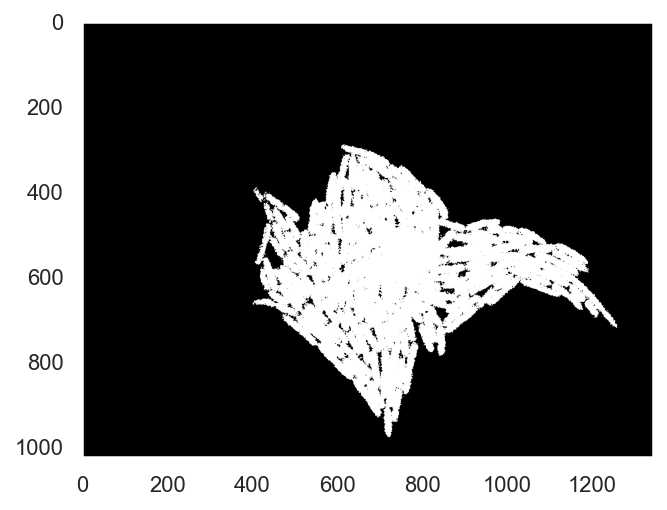

In [59]:
# Define threshold
thresh = 0.4

# Find pixels associated with cells
im_thresh = im_float > thresh

# Show segmented image
plt.imshow(im_thresh, cmap=plt.cm.Greys_r)
plt.grid(False)

This worked pretty well. However, we see that we do not clearly resolve the edges between cells, and in some region the image looks more like a lawn. There are way more sophisticated approaches to segmentation that would allow us to do that as well. But for now, simple thresholding is good enough for us. To find a good value for the threshold, we can use a the package `panel` to create a slider that let's us change the parameter on the fly!

Column
    [0] FloatSlider(name='Threshold slider', step=0.01, value=0.4)
    [1] ParamFunction(function)
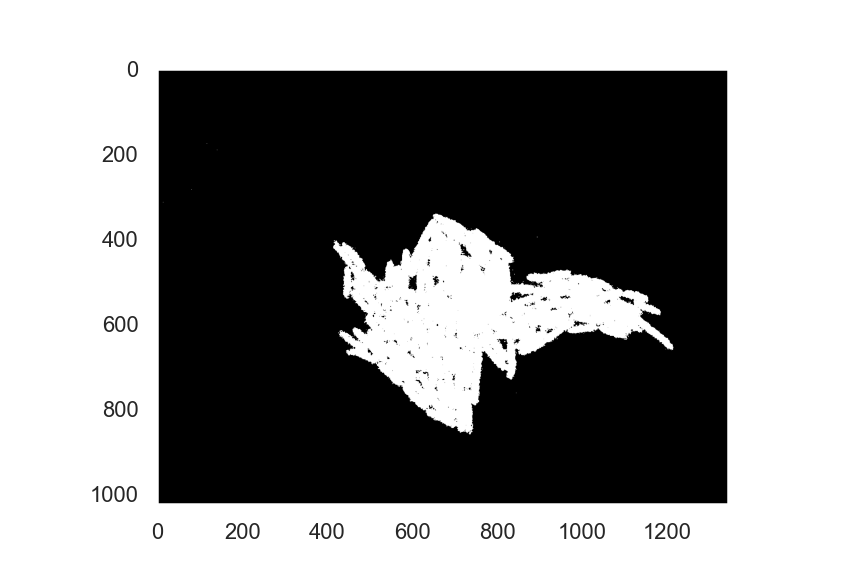

In [40]:
# Define slider using panel
thresh_slider = pn.widgets.FloatSlider(
    name='Threshold slider',
    start=0,
    end=1,
    step=0.01,
    value=0.4
)

# Define interactive plot
@pn.depends(thresh_slider.param.value)
def get_plot(thresh):
    fig, ax = plt.subplots(1, 1) # initialize empty plot
    ax.imshow(im_float > thresh,
               cmap = plt.cm.Greys_r)
    ax.grid(False)
    plt.close(fig)
    return fig

# Arrange interactive plot
pn.Column(
    thresh_slider,
    get_plot
)

Now it is time to process all images. Before we do that, we need to sort the images by their time stamp.

In [60]:
files = np.sort(files)
files

array(['../../data/ecoli_growth/ecoli_TRITC_00.tif',
       '../../data/ecoli_growth/ecoli_TRITC_01.tif',
       '../../data/ecoli_growth/ecoli_TRITC_02.tif',
       '../../data/ecoli_growth/ecoli_TRITC_03.tif',
       '../../data/ecoli_growth/ecoli_TRITC_04.tif',
       '../../data/ecoli_growth/ecoli_TRITC_05.tif',
       '../../data/ecoli_growth/ecoli_TRITC_06.tif',
       '../../data/ecoli_growth/ecoli_TRITC_07.tif',
       '../../data/ecoli_growth/ecoli_TRITC_08.tif',
       '../../data/ecoli_growth/ecoli_TRITC_09.tif',
       '../../data/ecoli_growth/ecoli_TRITC_10.tif',
       '../../data/ecoli_growth/ecoli_TRITC_11.tif',
       '../../data/ecoli_growth/ecoli_TRITC_12.tif',
       '../../data/ecoli_growth/ecoli_TRITC_13.tif',
       '../../data/ecoli_growth/ecoli_TRITC_14.tif',
       '../../data/ecoli_growth/ecoli_TRITC_15.tif',
       '../../data/ecoli_growth/ecoli_TRITC_16.tif',
       '../../data/ecoli_growth/ecoli_TRITC_17.tif',
       '../../data/ecoli_growth/ecoli_TRITC_18

Now we can interate through the images and perform the segmentation. We store the total number of pixels that belong to cells, which is proportional to the area occupied by the colony.

In [61]:
# Initialize array to save areas
area_array = np.zeros(len(files))

for i, file in enumerate(files):
    # 1. Read file into memory
    im = skimage.io.imread(file)
    # 2. Nomalize image
    im_float = (im - im.min()) / (im.max() - im.min())
    # 3. Apply threshold
    im_thresh = im_float > thresh
    # 4. Save number of pixels occupied by cells
    area_array[i] = np.sum(im_thresh)
    


Let's plot the results! The images were taken every 5 minutes, so we use that to scale the x-axis accordingly.

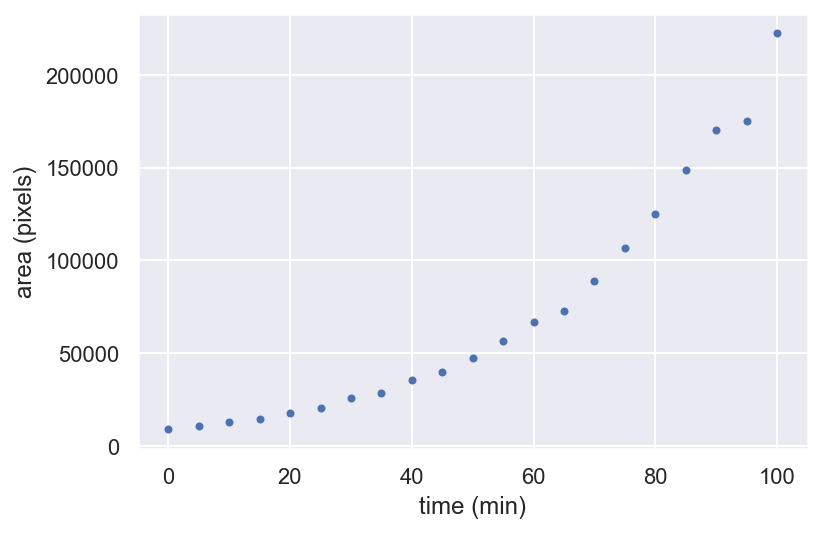

In [62]:
# Define time resolution of images
dt = 5  # min

# Define array for measurement times
time = np.arange(len(files)) * dt

# Plot time vs area
plt.plot(time, area_array, '.')

# Label our axis
plt.xlabel('time (min)')
plt.ylabel('area (pixels)');

This looks already pretty exponential. Let's put the y-axis on a log-scale.

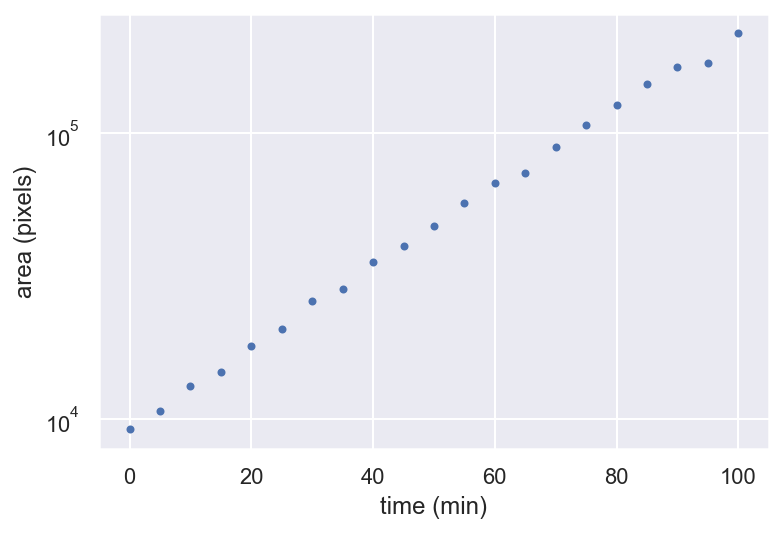

In [64]:
# Plot time vs area
plt.plot(time, area_array, '.')
# Change y axis to log scale
plt.yscale('log')
# Label our axis
plt.xlabel('time (min)')
plt.ylabel('area (pixels)');

If the data is linear on a semi log plot (y-axis), it is a clear sign for an exponential curve. To get a feeling for the range of growth rates that might give a good fit to the data, we can use a dashboard with the package `panel`. This allows us to manipulate a parameter and automatically update a plot everytime we change the parameter, without having to run the cell again.

Column
    [0] Markdown(str)
    [1] FloatSlider(end=0.1, name='growth rate', start=0.01, step=0.001, value=0.03)
    [2] ParamFunction(function)
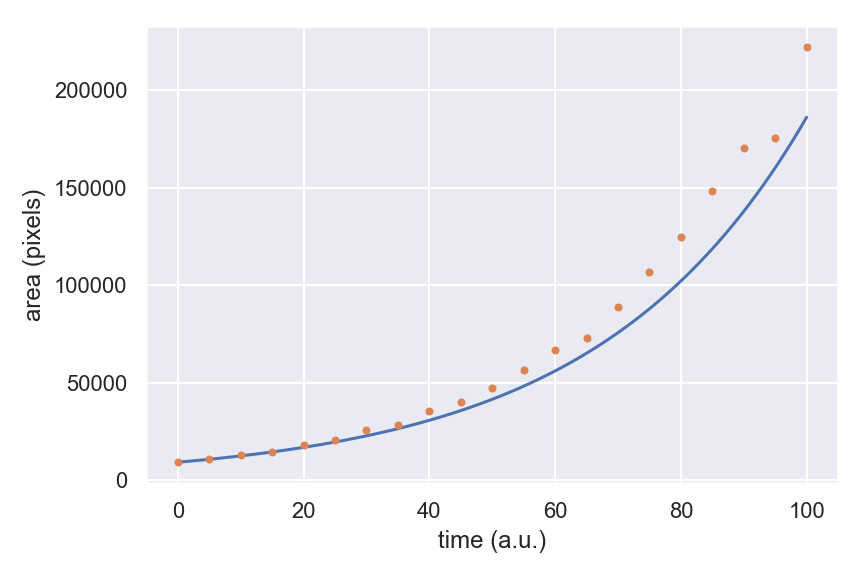

In [81]:
# Define time array for theory curve
time_array = np.linspace(0, time.max(), 100)

# Define slider for growth rate
k_slider = pn.widgets.FloatSlider(
    name='growth rate',
    start=0.01,
    end=0.1,
    step=0.001,
    value=0.03,
)

# Use panel to pass parameter to function
@pn.depends(k_slider.param.value)
def growth_plot(k):
    # Compute area
    area_theory = area_array[0] * np.exp(k * time_array)
    # Initialize figure
    fig, ax = plt.subplots(1, 1)
    # Plot theory
    ax.plot(time_array, area_theory)
    # Plot data
    ax.plot(time, area_array, '.')
    # Label plot
    ax.set_xlabel('time (a.u.)')
    ax.set_ylabel('area (pixels)')
    plt.tight_layout()
    plt.close(fig)
    return fig

# Arrange plot
pn.Column(
    '## Exponential Growth',
    k_slider,
    growth_plot
)

Now let's find the growth rate that explains the data the best. Therefore, we minimize the sum squared residuals. That means, we take the difference of each data point to the expectation from the theory, and sum up the square of these differences. The set of parameters which minimizes this sum is determined to be the "best" fit. 

Let's write a function that computes the sum of squared residuals for a chosen parameter.

In [82]:
def err(areas, times, growth_rate):
    '''
    Function that computes error between theory and experiment
    Parameters
    ----------
    areas : array-like.
        Experimental value of colony areas
    times : array-like.
        Time where measurements were taken
    growth_rate : float.
        Growth rate.
    
    Returns
    -------
    chi_squared : float.
        Sum of the square of the error between theory and data
    '''
    # Compute theoretical area
    area_theory = areas[0] * np.exp(growth_rate * times)
    
    # Compute sum of squared residuals
    r_squ = np.sum((area_theory - areas)**2)
    
    return r_squ

Now that we have the function in hand, we can apply it to a range of growth rates. We already guessed that the growth rate is about 0.03/min, so let's explore a range of growth rates around this value.

In [94]:
# Define array of growth rates to evaluate
k_array = np.linspace(0.02, 0.05, 200)

# Initialize array to save the values for sums of residuals
residuals = np.zeros(len(k_array))

# Loop through growth rates
for i, k in enumerate(k_array):
    # Compute and store errors
    residuals[i] = err(area_array, time, k)

Let's have a look at the squared residuals.

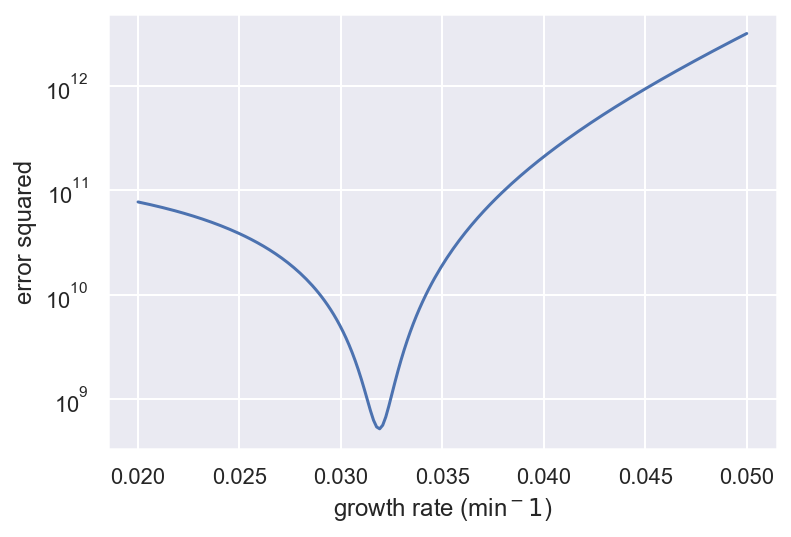

In [95]:
plt.plot(k_array, residuals)
plt.yscale('log')
# Label axis
plt.xlabel('growth rate (min$^-1$)')
plt.ylabel('error squared');

This plot reinforces our guess that the optimal growth rate is about 0.03/min. We can find the best guess for a growth rate by looking for the minimum in the array.

In [101]:
# find index of optimal growth rate
k_idx = np.argmin(residuals)

# Extract value of optimal growth rate
k_opt = k_array[k_idx]

print(f'optimal growth rate: {np.round(k_opt, 3)} min**-1')

optimal growth rate: 0.032 min**-1


Our final best guess for a growth rate is about 0.032/min, which equals a doubling time of about 22 minutes, which is around the doubling time of *E. coli* that we observe in the lab! Finally, let's have a look at the theory curve that we determined to fit the data "best".

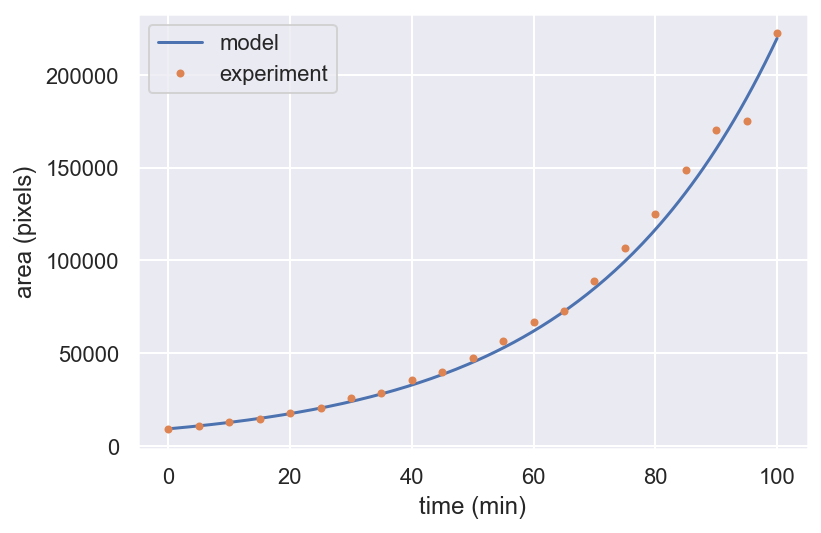

In [55]:
# Define time array for smooth plot
time_array = np.linspace(0, time.max(), 200)

# Evaluate model with optimal growth rate
area_model = area_array[0] * np.exp(k_opt * time_array)

# Plot theory
plt.plot(time_array, area_model, label='model')

# Plot data
plt.plot(time, area_array, '.', label='experiment')

# Label axis
plt.xlabel('time (min)')
plt.ylabel('area (pixels)')

plt.legend();